In [30]:
!pip install tensorflow keras numpy scikit-learn matplotlib carbontracker

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tensorflow.keras.datasets import cifar10
from carbontracker.tracker import CarbonTracker
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from google.colab import drive
import os



print("TensorFlow version:", tf.__version__)
print("Setup complete!")

TensorFlow version: 2.19.0
Setup complete!


#Data Preparation

In [31]:
def prepare_cifar_data():
    """Download, normalize, and split CIFAR10 data (45k train / 5k val / 10k test)"""

    print("Downloading CIFAR10 data...")
    (x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()


    x_train_full = x_train_full.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    # Convert to one-hot
    y_train_full = to_categorical(y_train_full, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    np.random.seed(42)  # for reproducibility
    perm = np.random.permutation(len(x_train_full))
    x_train_full, y_train_full = x_train_full[perm], y_train_full[perm]

    x_val = x_train_full[:5000]
    y_val = y_train_full[:5000]
    x_train = x_train_full[5000:]
    y_train = y_train_full[5000:]

    print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


    return (x_train, y_train), (x_val, y_val), (x_test, y_test)


(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_cifar_data()


Train: (45000, 32, 32, 3), Val: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


# === Masking utilities to prevent pruned weights from regrowing ===


In [32]:
def _build_weight_masks_from_weights(weights_list):
    return [np.where(w != 0.0, 1.0, 0.0).astype(w.dtype) for w in weights_list]


def build_model_masks(model):
    layer_to_masks = []
    for layer in model.layers:
        weights = layer.get_weights()
        if not weights:
            layer_to_masks.append(None)
            continue
        layer_to_masks.append(_build_weight_masks_from_weights(weights))
    return layer_to_masks


class MaskWeights(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_to_masks):
        super().__init__()
        self.model_ref = model
        self.layer_to_masks = layer_to_masks

    def on_train_batch_end(self, batch, logs=None):
        for layer, masks in zip(self.model_ref.layers, self.layer_to_masks):
            if masks is None:
                continue
            weights = layer.get_weights()
            if not weights:
                continue
            masked = [w * m for w, m in zip(weights, masks)]
            layer.set_weights(masked)


In [33]:
def model_sparsity(model):
    total, zeros = 0, 0
    per_layer = []
    for layer in model.layers:
        ws = layer.get_weights()
        if not ws:
            continue
        layer_total, layer_zeros = 0, 0
        for w in ws:
            layer_total += w.size
            layer_zeros += np.count_nonzero(w == 0.0)
        total += layer_total
        zeros += layer_zeros
        per_layer.append((layer.name, layer_zeros / layer_total if layer_total else 0.0))
    overall = zeros / total if total else 0.0
    return overall, per_layer

def evaluate_on_test(model, x_test, y_test, name="model"):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    overall_s, _ = model_sparsity(model)
    print(f"{name}: test_acc={acc:.4f}, test_loss={loss:.4f}, sparsity={overall_s*100:.2f}%")
    return {"name": name, "test_acc": acc, "test_loss": loss, "sparsity": overall_s}

Overall_results = []

# Training

In [34]:
#Defining Conv2
#model = models.Sequential([
    #layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D(pool_size=(2, 2)),

    #layers.Flatten(),
    #layers.Dense(256, activation='relu'),
    #layers.Dense(256, activation='relu'),
    #layers.Dense(10, activation='softmax')
#])




#Compiling the model
#model.compile(optimizer=optimizers.Adam(learning_rate=2e-4),
            #loss='categorical_crossentropy',
            #metrics=['accuracy'])

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])


#Compiling the model
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

class BestWeights(Callback):
    def __init__(self, monitor='val_loss', mode='min'):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.best_value = np.inf if mode == 'min' else -np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        improved = (current < self.best_value) if self.mode == 'min' else (current > self.best_value)
        if improved:
            self.best_value = current
            self.best_weights = self.model.get_weights()

In [35]:
#Training the model (keep best weights in memory)
best_cb_initial = BestWeights(monitor='val_loss', mode='min')
history = model.fit(
    x_train,
    y_train,
    epochs=26,
    batch_size=60,
    validation_data=(x_val, y_val),
    callbacks=[best_cb_initial],
    verbose=1)

# Capture last-epoch weights, then restore best weights found during training
initial_last_epoch_weights = model.get_weights()
if best_cb_initial.best_weights is not None:
    model.set_weights(best_cb_initial.best_weights)

# best_model holds best-epoch weights; final_model holds last-epoch weights
best_model = model
final_model = models.clone_model(model)
final_model.build(model.input_shape)
final_model.set_weights(initial_last_epoch_weights)



Epoch 1/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.3296 - loss: 1.8126 - val_accuracy: 0.5304 - val_loss: 1.3060
Epoch 2/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5589 - loss: 1.2252 - val_accuracy: 0.5982 - val_loss: 1.1037
Epoch 3/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6484 - loss: 0.9963 - val_accuracy: 0.6494 - val_loss: 0.9999
Epoch 4/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7032 - loss: 0.8413 - val_accuracy: 0.6944 - val_loss: 0.8770
Epoch 5/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7532 - loss: 0.7116 - val_accuracy: 0.7144 - val_loss: 0.8060
Epoch 6/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7907 - loss: 0.6029 - val_accuracy: 0.7396 - val_loss: 0.7522
Epoch 7/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8208 - loss: 0.5165 - val_accuracy: 0.7474 - val_loss: 0.7440
Epoch 8/26
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8567 - loss: 0.4123 - val_accuracy: 

In [36]:
#Evaluating the model:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7475 - loss: 0.7429
Test accuracy: 74.75%


In [37]:
Overall_results.append(evaluate_on_test(final_model, x_test, y_test, name="dense_final_initial"))


dense_final_initial: test_acc=0.7379, test_loss=1.6580, sparsity=0.00%


#Plot

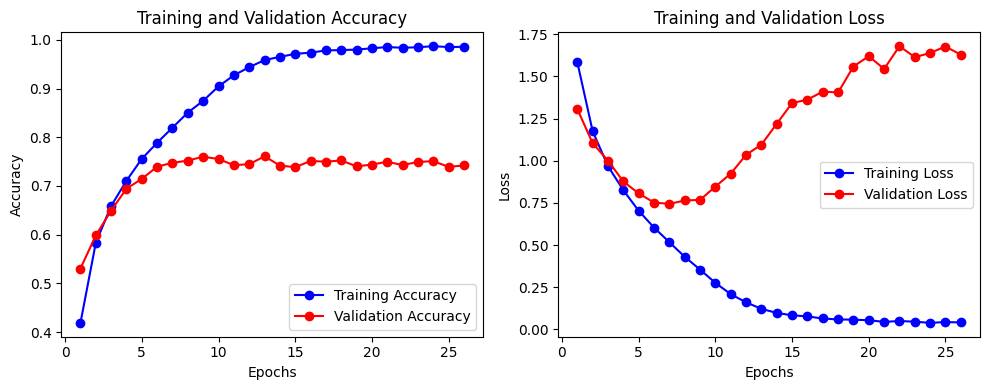

In [38]:
# Extract training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
Overall_results.append(evaluate_on_test(best_model, x_test, y_test, name="dense_best_initial"))

dense_best_initial: test_acc=0.7475, test_loss=0.7489, sparsity=0.00%


# Pruning Function



In [52]:
def prune_weights(prune_fraction=0.1, existing_masks_best=None):
    """Globally prune exactly a fraction using quantile threshold with selection.

    - Compute global threshold over all active diffs |w_best - w_final| (excluding last layer).
    - Let k = ceil(prune_fraction * num_active). Prune all diffs > threshold, then add
      exactly (k - count_gt) from the diffs == threshold group to reach k.
    - Return masks for retraining to enforce zeros.
    """

    print("=== Global mask-aware pruning (best_model only) start ===")

    all_active_diffs = []
    layer_tensor_active_masks = []
    layer_tensor_diffs = []
    concat_layer_idx = []
    concat_tensor_idx = []
    concat_flat_pos = []

    for i, (layer_best, layer_final) in enumerate(zip(best_model.layers, final_model.layers)):
        weights_best = layer_best.get_weights()
        weights_final = layer_final.get_weights()

        if not weights_best:
            layer_tensor_active_masks.append(None)
            layer_tensor_diffs.append(None)
            continue

        if i == len(best_model.layers) - 1:  # skip last layer
            tensor_active_masks = [(wb != 0.0).astype(wb.dtype) for wb in weights_best]
            tensor_active_flat = [np.array([], dtype=np.int64) for _ in weights_best]
            layer_tensor_active_masks.append(tensor_active_masks)
            layer_tensor_diffs.append([np.zeros_like(wb, dtype=wb.dtype) for wb in weights_best])
            continue

        tensor_active_masks = []
        tensor_diffs = []
        for j, (w_best, w_final) in enumerate(zip(weights_best, weights_final)):
            prev_mask_best = None
            if existing_masks_best and existing_masks_best[i] is not None:
                prev_mask_best = existing_masks_best[i][j]
            if prev_mask_best is None:
                prev_mask_best = (w_best != 0.0).astype(w_best.dtype)

            active_mask = prev_mask_best.astype(bool)
            diff = np.abs(w_best - w_final)

            tensor_active_masks.append(active_mask)
            tensor_diffs.append(diff)
            if active_mask.any():
                active_flat = np.flatnonzero(active_mask.ravel())
                all_active_diffs.append(diff.ravel()[active_flat])
                concat_layer_idx.append(np.full(active_flat.size, i, dtype=np.int64))
                concat_tensor_idx.append(np.full(active_flat.size, j, dtype=np.int64))
                concat_flat_pos.append(active_flat.astype(np.int64))

        layer_tensor_active_masks.append(tensor_active_masks)
        layer_tensor_diffs.append(tensor_diffs)

    selected_by_tensor = {}
    if prune_fraction > 0.0 and len(all_active_diffs) > 0:
        concat = np.concatenate(all_active_diffs) if len(all_active_diffs) > 0 else np.array([], dtype=np.float32)
        concat_layer_idx = np.concatenate(concat_layer_idx) if len(concat_layer_idx) > 0 else np.array([], dtype=np.int64)
        concat_tensor_idx = np.concatenate(concat_tensor_idx) if len(concat_tensor_idx) > 0 else np.array([], dtype=np.int64)
        concat_flat_pos = np.concatenate(concat_flat_pos) if len(concat_flat_pos) > 0 else np.array([], dtype=np.int64)

        num_active = int(concat.size)
        k = int(np.ceil(prune_fraction * num_active))
        if k > 0 and num_active > 0:
            thr = np.quantile(concat, 1 - prune_fraction)
            gt_idx = np.where(concat > thr)[0]
            eq_idx = np.where(concat == thr)[0]

            if gt_idx.size >= k:
                order = np.argsort(-concat[gt_idx], kind='stable')[:k]
                chosen = gt_idx[order]
            else:
                need = k - gt_idx.size
                eq_sorted = np.argsort(-concat[eq_idx], kind='stable')  # prefer larger equals
                chosen = np.concatenate([gt_idx, eq_idx[eq_sorted[:need]]]) if need > 0 else gt_idx

            for g in chosen:
                li = int(concat_layer_idx[g]); tj = int(concat_tensor_idx[g]); fp = int(concat_flat_pos[g])
                selected_by_tensor.setdefault((li, tj), []).append(fp)

    masks_best_out = []
    for i, layer_best in enumerate(best_model.layers):
        weights_best = layer_best.get_weights()
        if not weights_best:
            masks_best_out.append(None)
            continue

        if i == len(best_model.layers) - 1:
            masks_best_out.append(_build_weight_masks_from_weights(weights_best))
            continue

        new_weights_best = []
        layer_masks_best = []

        for j, w_best in enumerate(weights_best):
            active_mask = layer_tensor_active_masks[i][j]
            new_mask_bool = active_mask.copy()

            key = (i, j)
            if key in selected_by_tensor and np.any(active_mask):
                nmf = new_mask_bool.ravel()
                nmf[np.array(selected_by_tensor[key], dtype=np.int64)] = False
                new_mask_bool = nmf.reshape(new_mask_bool.shape)

            new_mask = new_mask_bool.astype(w_best.dtype)
            pruned_weights_best = w_best * new_mask

            new_weights_best.append(pruned_weights_best)
            layer_masks_best.append(new_mask)

        layer_best.set_weights(new_weights_best)
        masks_best_out.append(layer_masks_best)

    print("=== Global mask-aware pruning (best_model only) done ===")
    return masks_best_out

#add checkpoint

In [53]:
#computes if two models weights are very close to each other
def models_have_same_weights(model_a, model_b, tol=1e-7):
    for wa, wb in zip(model_a.get_weights(), model_b.get_weights()):
        if not np.allclose(wa, wb, atol=tol):
            return False
    return True


pruning in retraining run number 0
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7531 - loss: 0.7011 - val_accuracy: 0.7324 - val_loss: 0.7743
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8157 - loss: 0.5297 - val_accuracy: 0.7366 - val_loss: 0.7726
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8357 - loss: 0.4736 - val_accuracy: 0.7394 - val_loss: 0.7846
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8556 - loss: 0.4213 - val_accuracy: 0.7382 - val_loss: 0.8144
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8769 - loss: 0.3540 - val_accuracy: 0.7468 - val_loss: 0.7869
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8903 - loss: 0.3161 - val_accuracy: 0.7388 - val_loss: 0.8483
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.90

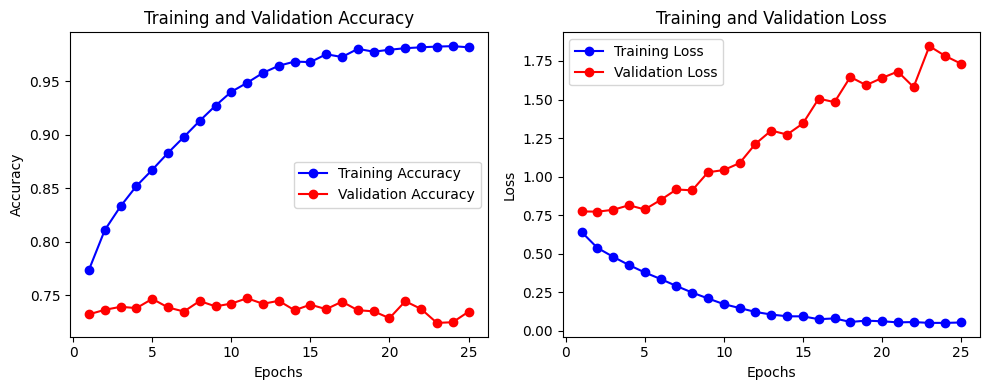

pruning in retraining run number 1
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7516 - loss: 0.7142 - val_accuracy: 0.7250 - val_loss: 0.7955
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.8119 - loss: 0.5440 - val_accuracy: 0.7414 - val_loss: 0.7492
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8290 - loss: 0.4937 - val_accuracy: 0.7410 - val_loss: 0.7624
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8391 - loss: 0.4603 - val_accuracy: 0.7330 - val_loss: 0.8101
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8517 - loss: 0.4218 - val_accuracy: 0.7394 - val_loss: 0.7886
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8738 - loss: 0.3774 - val_accuracy: 0.7352 - val_loss: 0.8285
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.87

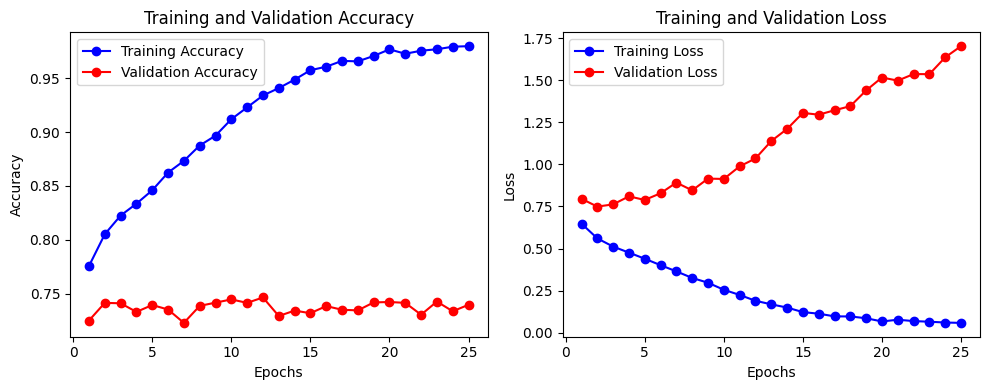

pruning in retraining run number 2
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7334 - loss: 0.7633 - val_accuracy: 0.7110 - val_loss: 0.8431
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7927 - loss: 0.5921 - val_accuracy: 0.7318 - val_loss: 0.7751
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8136 - loss: 0.5387 - val_accuracy: 0.6906 - val_loss: 0.8998
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8230 - loss: 0.5097 - val_accuracy: 0.7352 - val_loss: 0.7824
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8337 - loss: 0.4762 - val_accuracy: 0.7342 - val_loss: 0.8257
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8458 - loss: 0.4501 - val_accuracy: 0.7436 - val_loss: 0.7569
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.85

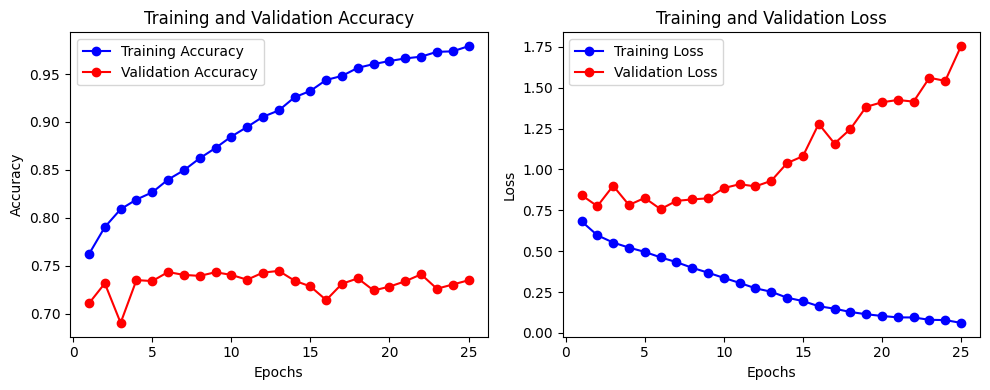

pruning in retraining run number 3
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7643 - loss: 0.6701 - val_accuracy: 0.7218 - val_loss: 0.7928
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8187 - loss: 0.5246 - val_accuracy: 0.7276 - val_loss: 0.8278
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8296 - loss: 0.4952 - val_accuracy: 0.7328 - val_loss: 0.8048
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8409 - loss: 0.4694 - val_accuracy: 0.7384 - val_loss: 0.7960
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8516 - loss: 0.4333 - val_accuracy: 0.7338 - val_loss: 0.8376
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8583 - loss: 0.4206 - val_accuracy: 0.7348 - val_loss: 0.8499
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.86

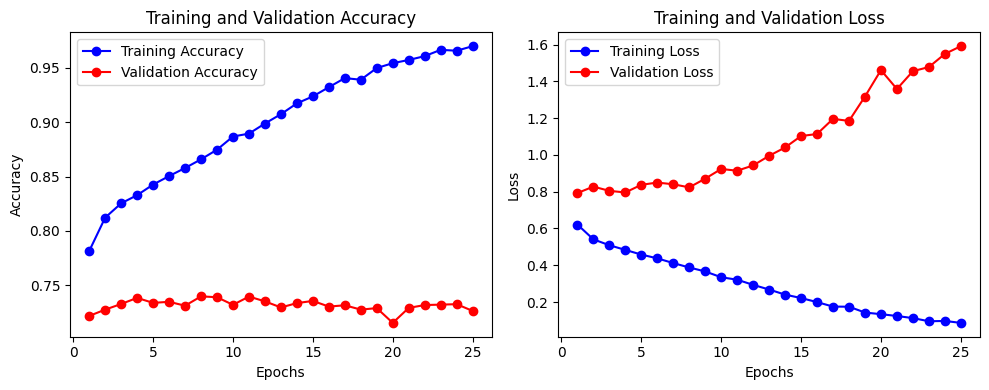

pruning in retraining run number 4
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.6958 - loss: 0.8839 - val_accuracy: 0.7130 - val_loss: 0.8324
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7679 - loss: 0.6614 - val_accuracy: 0.7212 - val_loss: 0.8090
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7880 - loss: 0.6110 - val_accuracy: 0.7158 - val_loss: 0.8462
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7978 - loss: 0.5788 - val_accuracy: 0.7202 - val_loss: 0.8202
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.8101 - loss: 0.5458 - val_accuracy: 0.7274 - val_loss: 0.8075
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8208 - loss: 0.5201 - val_accuracy: 0.7300 - val_loss: 0.8245
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.82

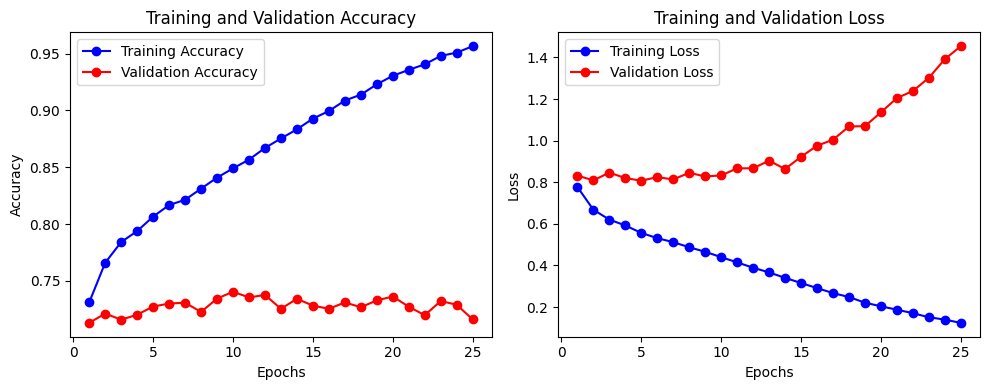

pruning in retraining run number 5
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7058 - loss: 0.8485 - val_accuracy: 0.7026 - val_loss: 0.8662
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7670 - loss: 0.6778 - val_accuracy: 0.7118 - val_loss: 0.8425
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7802 - loss: 0.6322 - val_accuracy: 0.7174 - val_loss: 0.8275
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7931 - loss: 0.5979 - val_accuracy: 0.7150 - val_loss: 0.8173
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8037 - loss: 0.5734 - val_accuracy: 0.7222 - val_loss: 0.8172
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.8094 - loss: 0.5522 - val_accuracy: 0.7126 - val_loss: 0.8530
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.81

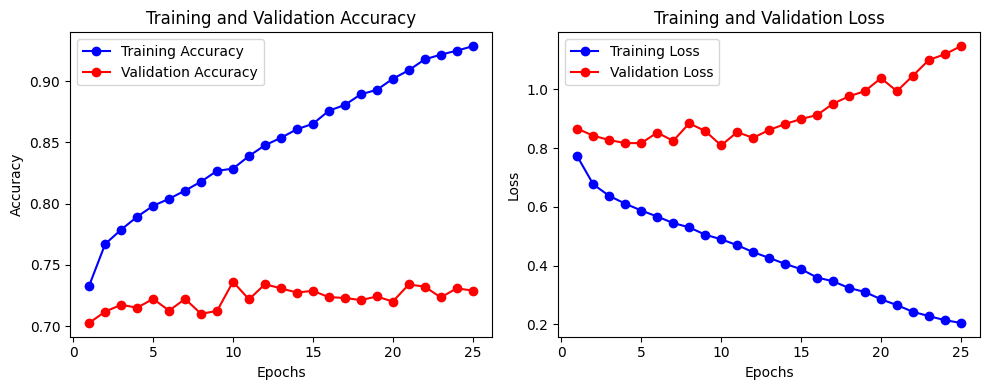

pruning in retraining run number 6
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6821 - loss: 0.9325 - val_accuracy: 0.6928 - val_loss: 0.8867
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7639 - loss: 0.6866 - val_accuracy: 0.7120 - val_loss: 0.8483
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7777 - loss: 0.6426 - val_accuracy: 0.6940 - val_loss: 0.8926
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7891 - loss: 0.6092 - val_accuracy: 0.6932 - val_loss: 0.9326
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7975 - loss: 0.5885 - val_accuracy: 0.6978 - val_loss: 0.8939
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8049 - loss: 0.5626 - val_accuracy: 0.7248 - val_loss: 0.8261
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.81

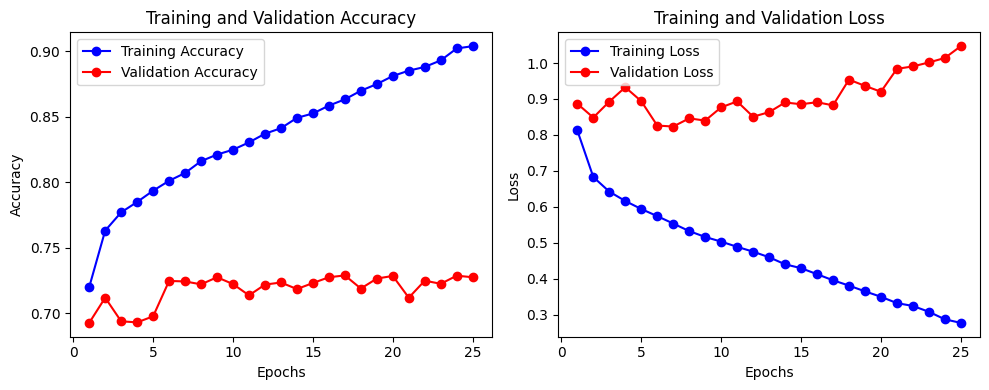

pruning in retraining run number 7
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.5733 - loss: 1.2232 - val_accuracy: 0.6540 - val_loss: 0.9851
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6991 - loss: 0.8614 - val_accuracy: 0.6596 - val_loss: 0.9683
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7262 - loss: 0.7856 - val_accuracy: 0.6760 - val_loss: 0.9229
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7425 - loss: 0.7500 - val_accuracy: 0.6828 - val_loss: 0.9109
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.7479 - loss: 0.7168 - val_accuracy: 0.6860 - val_loss: 0.9199
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7572 - loss: 0.6968 - val_accuracy: 0.7054 - val_loss: 0.8665
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.76

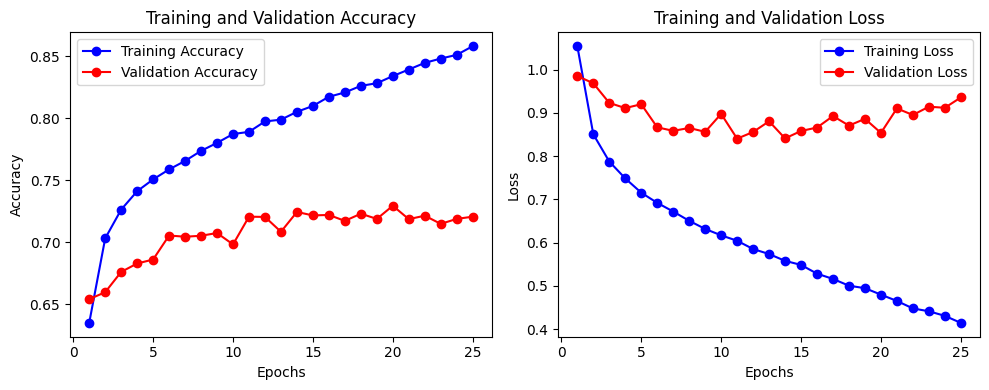

pruning in retraining run number 8
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3687 - loss: 1.7904 - val_accuracy: 0.5256 - val_loss: 1.3327
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.5584 - loss: 1.2665 - val_accuracy: 0.5814 - val_loss: 1.1671
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.6071 - loss: 1.1189 - val_accuracy: 0.6106 - val_loss: 1.0766
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.6440 - loss: 1.0277 - val_accuracy: 0.6288 - val_loss: 1.0384
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.6640 - loss: 0.9706 - val_accuracy: 0.6424 - val_loss: 1.0013
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6780 - loss: 0.9225 - val_accuracy: 0.6516 - val_loss: 0.9923
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.68

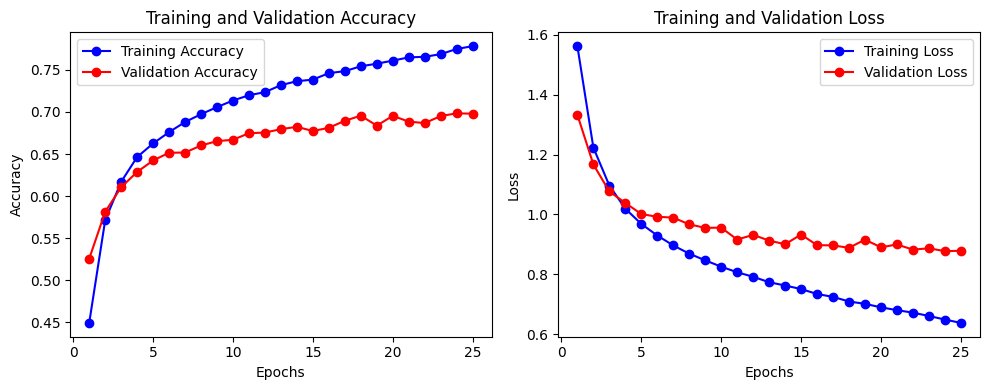

pruning in retraining run number 9
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.0987 - loss: 2.3117 - val_accuracy: 0.0972 - val_loss: 2.3034
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1015 - loss: 2.3031 - val_accuracy: 0.0972 - val_loss: 2.3026
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.1012 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3025
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1059 - loss: 2.3023 - val_accuracy: 0.1082 - val_loss: 2.3024
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1105 - loss: 2.3023 - val_accuracy: 0.1276 - val_loss: 2.3019
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1208 - loss: 2.3017 - val_accuracy: 0.1308 - val_loss: 2.2993
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.13

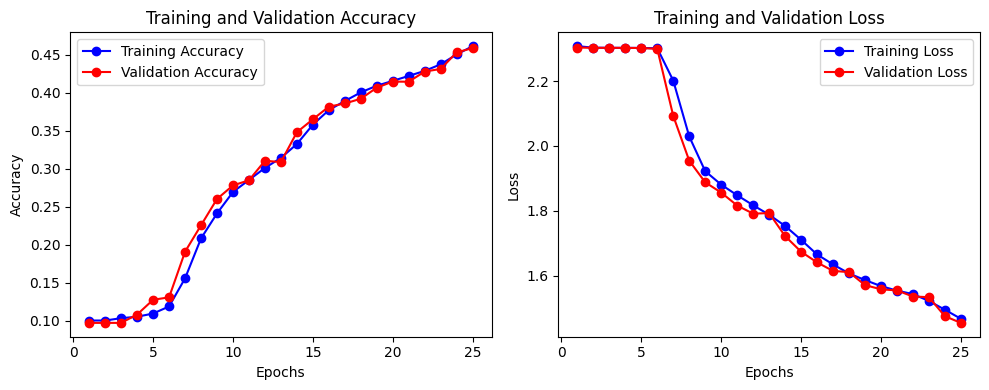

skipping pruning in retraining run number 10
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.4660 - loss: 1.4535 - val_accuracy: 0.4628 - val_loss: 1.4395
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.4814 - loss: 1.4213 - val_accuracy: 0.4776 - val_loss: 1.4276
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.4844 - loss: 1.4174 - val_accuracy: 0.4806 - val_loss: 1.4113
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.4881 - loss: 1.4003 - val_accuracy: 0.4750 - val_loss: 1.4181
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.4986 - loss: 1.3842 - val_accuracy: 0.4920 - val_loss: 1.3955
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.4970 - loss: 1.3838 - val_accuracy: 0.4926 - val_loss: 1.3924
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accu

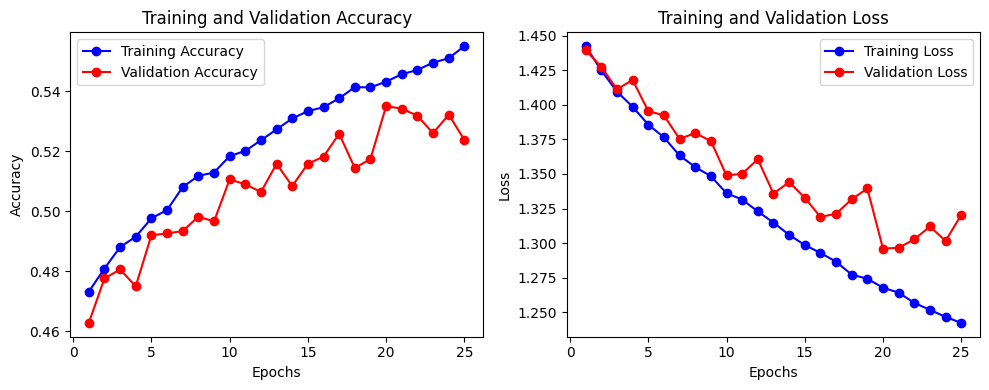

pruning in retraining run number 11
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0992 - loss: 2.3116 - val_accuracy: 0.0972 - val_loss: 2.3055
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.0979 - loss: 2.3056 - val_accuracy: 0.0972 - val_loss: 2.3035
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1018 - loss: 2.3034 - val_accuracy: 0.0972 - val_loss: 2.3028
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.0992 - loss: 2.3030 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1009 - loss: 2.3027 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1004 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.0

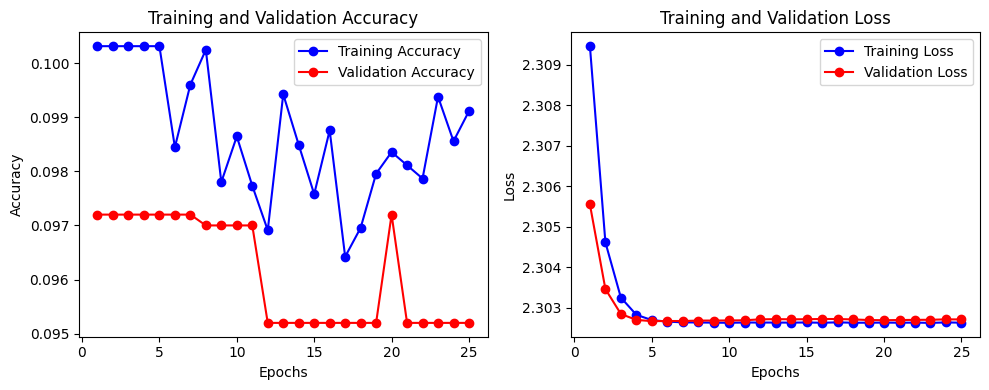

pruning in retraining run number 12
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0989 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.0960 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.0988 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0994 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.1021 - loss: 2.3025 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1008 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1

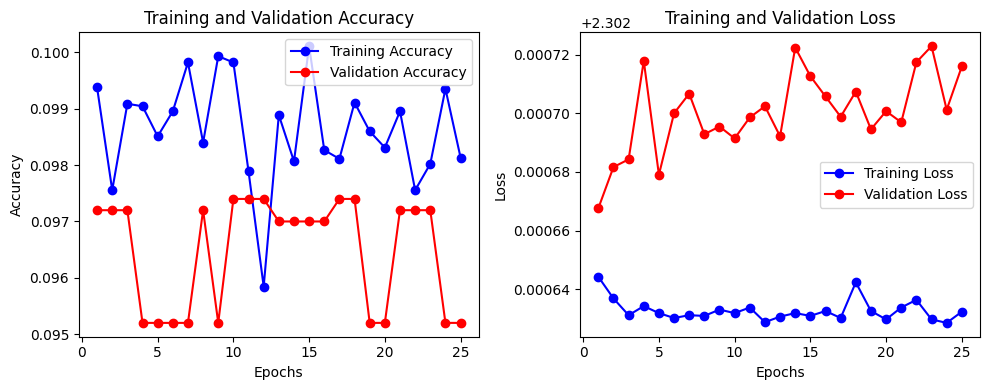

pruning in retraining run number 13
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0964 - loss: 2.3027 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.0979 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.1005 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0976 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.1034 - loss: 2.3026 - val_accuracy: 0.0972 - val_loss: 2.3027
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0983 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0

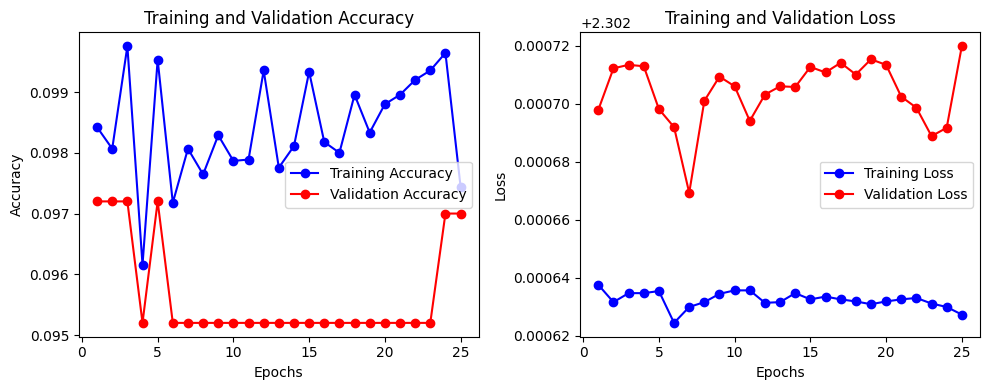

pruning in retraining run number 14
=== Global mask-aware pruning (best_model only) start ===
=== Global mask-aware pruning (best_model only) done ===
Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0996 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.0990 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1009 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.0972 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.0985 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.1010 - loss: 2.3026 - val_accuracy: 0.0952 - val_loss: 2.3027
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.0

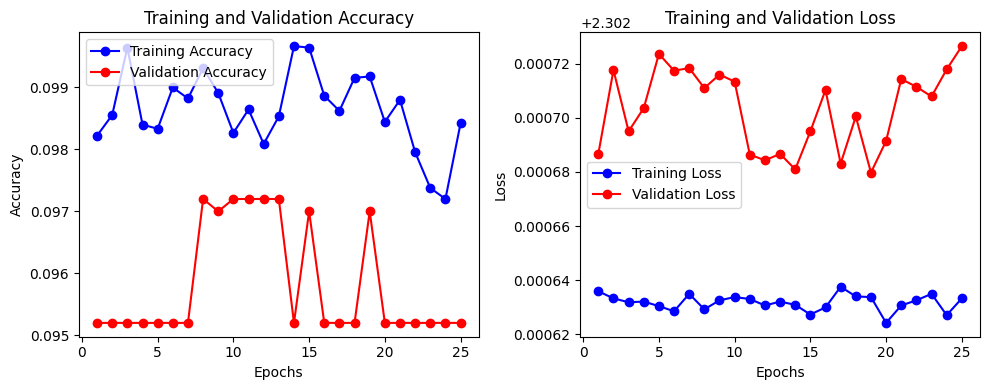

In [54]:
# === Multiple retraining runs for plotting ===
num_retrains = 15
epochs_per_retrain = 25


best_val_losses = [min(history.history['val_loss'])]
best_val_accs = [history.history['val_accuracy'][np.argmin(history.history['val_loss'])]]
val_loss_runs = []


val_loss_runs.append(np.array(history.history['val_loss']))
current_masks = None

for run_idx in range(num_retrains):

    if models_have_same_weights(final_model, best_model):
        print(f'skipping pruning in retraining run number {run_idx}')
        current_masks = prune_weights(
            prune_fraction = 0.0,
            existing_masks_best=current_masks
        )
    else:
        print(f'pruning in retraining run number {run_idx}')
        current_masks = prune_weights(
            prune_fraction=0.1,
            existing_masks_best=current_masks
        )

    best_cb_retrain = BestWeights(monitor='val_loss', mode='min')

    history_r = best_model.fit(
        x_train, y_train,
        epochs=epochs_per_retrain, batch_size=60,
        validation_data=(x_val, y_val),
        callbacks=[MaskWeights(best_model, current_masks), best_cb_retrain],
        verbose=1,
    )

    last_epoch_weights = best_model.get_weights()
    if best_cb_retrain.best_weights is not None:
        best_model.set_weights(best_cb_retrain.best_weights)
    final_model.set_weights(last_epoch_weights)

    r = evaluate_on_test(best_model, x_test, y_test, name=f"pruned_retrain_run_{run_idx+1}")
    Overall_results.append(r)

    val_losses = np.array(history_r.history['val_loss'])
    val_accs = np.array(history_r.history['val_accuracy'])
    val_loss_runs.append(val_losses)
    best_idx = int(np.argmin(val_losses))
    best_val_losses.append(float(val_losses[best_idx]))
    best_val_accs.append(float(val_accs[best_idx]))





    # ------------  plotting the curve of performance for each run -------------

    print("First 20 weights of the first layer (kernel) of the best_model:")
    _w_best = best_model.layers[0].get_weights()[0].flatten()
    print(_w_best[:50])

    print("\nFirst 20 weights of the first layer (kernel) of the final_model:")
    _w_final = final_model.layers[0].get_weights()[0].flatten()
    print(_w_final[:50])

    train_acc = history_r.history['accuracy']
    val_acc = history_r.history['val_accuracy']
    train_loss = history_r.history['loss']
    val_loss = history_r.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()




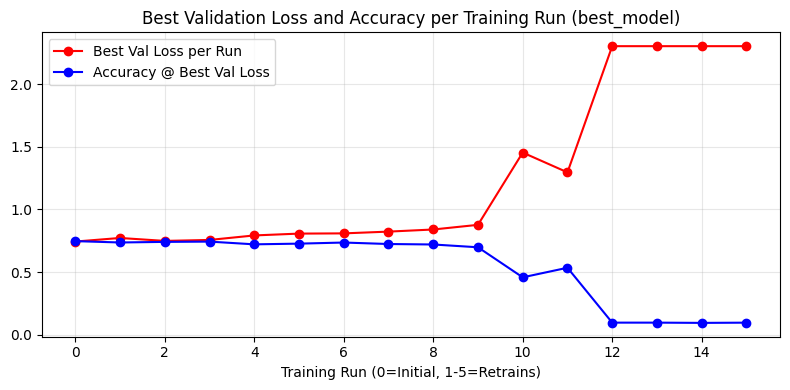

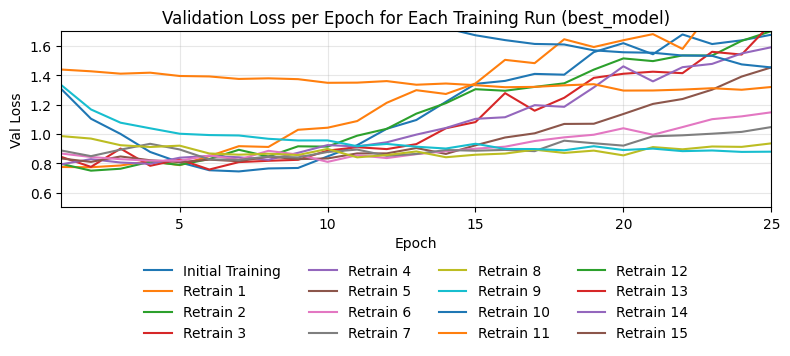

In [63]:
plt.figure(figsize=(8, 4))
xs = np.arange(0, num_retrains + 1)
plt.plot(xs, best_val_losses, 'r-o', label='Best Val Loss per Run')
plt.plot(xs, best_val_accs, 'b-o', label='Accuracy @ Best Val Loss')
plt.xlabel('Training Run (0=Initial, 1-5=Retrains)')
plt.title('Best Validation Loss and Accuracy per Training Run (best_model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
labels = ['Initial Training'] + [f'Retrain {i}' for i in range(1, num_retrains + 1)]
for i, losses in enumerate(val_loss_runs):
    plt.plot(np.arange(1, len(losses) + 1), losses, label=labels[i])
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.title('Validation Loss per Epoch for Each Training Run (best_model)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)
plt.xlim(1,25)
plt.ylim(0.5,1.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluating on Test Dataset

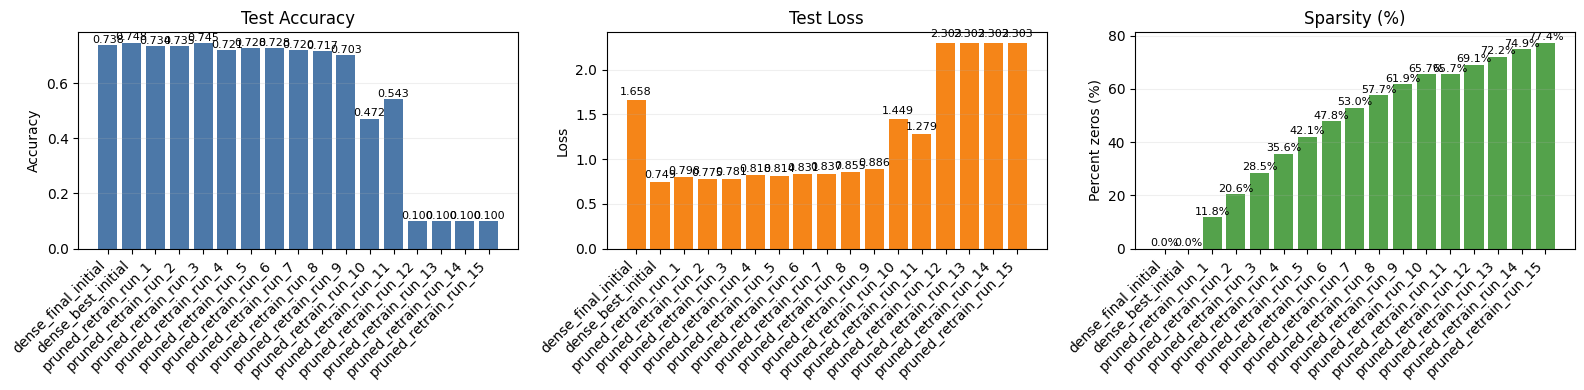


Summary (sorted by name):
          dense_best_initial | acc=0.7475 | loss=0.7489 | sparsity=0.0%
         dense_final_initial | acc=0.7379 | loss=1.6580 | sparsity=0.0%
        pruned_retrain_run_1 | acc=0.7337 | loss=0.7981 | sparsity=11.8%
       pruned_retrain_run_10 | acc=0.4715 | loss=1.4490 | sparsity=65.7%
       pruned_retrain_run_11 | acc=0.5429 | loss=1.2790 | sparsity=65.7%
       pruned_retrain_run_12 | acc=0.1000 | loss=2.3026 | sparsity=69.1%
       pruned_retrain_run_13 | acc=0.1000 | loss=2.3026 | sparsity=72.2%
       pruned_retrain_run_14 | acc=0.1000 | loss=2.3026 | sparsity=74.9%
       pruned_retrain_run_15 | acc=0.1000 | loss=2.3026 | sparsity=77.4%
        pruned_retrain_run_2 | acc=0.7351 | loss=0.7748 | sparsity=20.6%
        pruned_retrain_run_3 | acc=0.7448 | loss=0.7814 | sparsity=28.5%
        pruned_retrain_run_4 | acc=0.7214 | loss=0.8183 | sparsity=35.6%
        pruned_retrain_run_5 | acc=0.7284 | loss=0.8135 | sparsity=42.1%
        pruned_retrain_run

In [69]:
exclude_names = {'dense_final_initial'} | {f'pruned_retrain_run_{i}' for i in range(10, 16)}
filtered_results = [r for r in Overall_results if r.get('name') not in exclude_names]

names = [r.get('name', f'model_{i}') for i, r in enumerate(Overall_results)]
accs = [float(r.get('test_acc', float('nan'))) for r in Overall_results]
losses = [float(r.get('test_loss', float('nan'))) for r in Overall_results]
sparsities = [float(r.get('sparsity', float('nan'))) * 100.0 for r in Overall_results]  # to %

x = np.arange(len(names))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].bar(x, accs, color='#4c78a8')
axes[0].set_title('Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(x)
#axes[0].set_ylim(0.4,0.8)
axes[0].set_xticklabels(names, rotation=45, ha='right')
for i, v in enumerate(accs):
    if not np.isnan(v):
        axes[0].text(i, v + 0.001, f"{v:.3f}", ha='center', va='bottom', fontsize=8)
axes[0].grid(axis='y', alpha=0.2)

# Loss
axes[1].bar(x, losses, color='#f58518')
axes[1].set_title('Test Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(x)
#axes[1].set_ylim(0.70,0.95)
axes[1].set_xticklabels(names, rotation=45, ha='right')
for i, v in enumerate(losses):
    if not np.isnan(v):
        axes[1].text(i, v + max(0.01, 0.02 * v), f"{v:.3f}", ha='center', va='bottom', fontsize=8)
axes[1].grid(axis='y', alpha=0.2)

# Sparsity
axes[2].bar(x, sparsities, color='#54a24b')
axes[2].set_title('Sparsity (%)')
axes[2].set_ylabel('Percent zeros (%)')
axes[2].set_xticks(x)
#axes[2].set_ylim(0,70)
axes[2].set_xticklabels(names, rotation=45, ha='right')
for i, v in enumerate(sparsities):
    if not np.isnan(v):
        axes[2].text(i, v + 0.1, f"{v:.1f}%", ha='center', va='bottom', fontsize=8)
axes[2].grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

print("\nSummary (sorted by name):")
for name, acc, loss, sp in sorted(zip(names, accs, losses, sparsities), key=lambda t: t[0]):
    print(f"{name:>28s} | acc={acc:.4f} | loss={loss:.4f} | sparsity={sp:.1f}%")
